## RLlib PPO policy evaluation

In [1]:
import gym
import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo
from ray import serve

In [2]:
ray.init()

2022-07-05 16:53:37,610	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.12', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-05_16-53-35_664282_6284/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-05_16-53-35_664282_6284/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-07-05_16-53-35_664282_6284', 'metrics_export_port': 63556, 'gcs_address': '127.0.0.1:58315', 'address': '127.0.0.1:58315', 'node_id': 'c516d04aa537de6c33fd29d4286d01615ed23830c1eb8b73ebdbc978'})

In [3]:
from config import Config
from data_prep import DataPrep
from env import CMAPSSEnv
from VAE_dense import *
from tf_serve_models import TFEncoderDecoderModel

# Load options
serve.start()
TFEncoderDecoderModel.deploy(['./saved_models/encoder','./saved_models/decoder'])

const = Config()
neurons = const.VAE_neurons

# Data prep
# Load the 3rd batch of data which are for policy evaluation
data = DataPrep(file = const.file_path,
                num_settings = const.num_settings,
                num_sensors = const.num_sensors,
                num_units = const.num_units[2],
                prev_step_units = const.prev_step_units[2],
                step = const.step[2],
                normalization_type="01")

df = data.ReadData()
#print(df)

# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

# Environment types
env_types = ["batch", "intertemporal"]

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": const.num_settings+const.num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "models": [None, None],
    "env_type": env_types[1],
}

env_name = "CMAPSS_env"
env_wrapper_config = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)
register_env(env_name, lambda config: env_wrapper_config)

(ServeController pid=6336) 2022-07-05 16:53:41,176	INFO checkpoint_path.py:15 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=6336) 2022-07-05 16:53:41,283	INFO http_state.py:106 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:XVayib:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-07-05 16:53:41,933	INFO api.py:794 -- Started Serve instance in namespace '58830699-8fee-4281-8e1e-654328fb16ef'.
2022-07-05 16:53:41,937	INFO api.py:615 -- Updating deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
(HTTPProxyActor pid=6339) INFO:     Started server process [6339]
(ServeController pid=6336) 2022-07-05 16:53:42,013	INFO deployment_state.py:1210 -- Adding 1 replicas to deployment 'TFEncoderDecoderModel'. component=serve deployment=TFEncoderDecoderModel
2022-07-05 16:53:45,959	INFO api.py:630 -- Deployment 'TFEncoderDecoderModel' is ready at `http://127.0.0.1:800

In [4]:
# Locate checkpoints

checkpoint_path = "/Users/erotokritosskordilis/ray_results/CMAPSS_env/PPO_CMAPSS_env_faca9_00000_0_2022-07-05_12-10-25/checkpoint_000102/checkpoint-102"



In [5]:
# Restore agent from last checkpoint

agent = ppo.PPOTrainer(
    config={
            "env": env_name,
            "num_workers": 1,
            "num_gpus": 0,
            "log_level": "INFO",
            "explore": False,
            "model":{
                "fcnet_hiddens": const.VAE_neurons,
                "fcnet_activation": "relu",
                "free_log_std": True,
            }
        })

agent.restore(checkpoint_path)

2022-07-05 16:53:50,527	INFO trainer.py:2295 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-07-05 16:53:50,537	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(RolloutWorker pid=6347) 2022-07-05 16:53:54,699	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=6347) 2022-07-05 16:53:54,699	WARNING

In [6]:
env = gym.wrappers.FrameStack(CMAPSSEnv(**env_config), const.num_frames)

In [23]:
import bisect

obs, done = env.reset(), False
cntr = 0

s = bisect.bisect_left(np.cumsum(engine_lives), env.timestep)
steps_to_go = abs(env.timestep - np.cumsum(engine_lives[:s+1])[-1]) - 1
current_step = abs(engine_lives[s] - steps_to_go)
print(f'Current step: {current_step},System: {s}, System life: {engine_lives[s]}, Steps until failure: {steps_to_go}')

Current step: 25,System: 1, System life: 273, Steps until failure: 248


In [24]:
eval_data = np.empty([steps_to_go, const.num_frames, const.num_settings + const.num_sensors + 1])
eval_data.shape

(248, 100, 25)

In [25]:
while not done:
    action = agent.compute_single_action(obs)
    obs, _, done, _ = env.step(action)
    eval_data[cntr] = obs
    cntr += 1

In [26]:
eval_data_avg = np.empty([steps_to_go, const.num_settings + const.num_sensors + 1])

for i in range(steps_to_go):
    eval_data_avg[i] = np.mean(eval_data[i,:,:], axis=0)

eval_data_avg[:,0]

array([9.04717636e-01, 9.01005613e-01, 8.97284949e-01, 8.93551976e-01,
       8.89823598e-01, 8.86093032e-01, 8.82351328e-01, 8.78580581e-01,
       8.74824620e-01, 8.71064399e-01, 8.67283263e-01, 8.63495761e-01,
       8.59704177e-01, 8.55880429e-01, 8.52075378e-01, 8.48246499e-01,
       8.44434493e-01, 8.40615810e-01, 8.36776399e-01, 8.32903147e-01,
       8.29002058e-01, 8.25072704e-01, 8.21110564e-01, 8.17144104e-01,
       8.13168347e-01, 8.09189248e-01, 8.05193009e-01, 8.01191790e-01,
       7.97141082e-01, 7.93072069e-01, 7.88956246e-01, 7.84780122e-01,
       7.80587708e-01, 7.76400188e-01, 7.72172823e-01, 7.67951475e-01,
       7.63699304e-01, 7.59469942e-01, 7.55224725e-01, 7.50982113e-01,
       7.46740992e-01, 7.42517026e-01, 7.38237324e-01, 7.33909067e-01,
       7.29582240e-01, 7.25230519e-01, 7.20889486e-01, 7.16567824e-01,
       7.12218577e-01, 7.07844384e-01, 7.03381966e-01, 6.98908686e-01,
       6.94375706e-01, 6.89755925e-01, 6.85107627e-01, 6.80427689e-01,
      

In [27]:
test_engine_df = df.iloc[np.cumsum(engine_lives[:s])[-1]+current_step:np.cumsum(engine_lives[:s])[-1]+engine_lives[s],1:].reset_index(drop=True)

In [28]:
import pandas as pd

eval_df = pd.DataFrame(eval_data_avg, columns=df.columns[1:])
eval_df.head(10)

,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,0.904718,0.331077,0.418949,0.879338,0.640697,0.635771,0.651121,0.605179,0.634090,0.622318,...,0.602894,0.873876,0.599721,0.241173,0.558381,0.641241,0.780860,0.879434,0.612179,0.614778
1,0.901006,0.332632,0.420577,0.878677,0.638343,0.633631,0.649356,0.603517,0.631803,0.620083,...,0.600586,0.873243,0.598779,0.242020,0.556762,0.639504,0.779480,0.878869,0.609971,0.612523
2,0.897285,0.334185,0.422205,0.878015,0.635989,0.631491,0.647591,0.601855,0.629516,0.617848,...,0.598278,0.872609,0.597836,0.242866,0.555143,0.637767,0.778099,0.878303,0.607763,0.610268
3,0.893552,0.335739,0.423832,0.877354,0.633635,0.629351,0.645826,0.600193,0.627230,0.615614,...,0.595970,0.871976,0.596894,0.243712,0.553526,0.636030,0.776720,0.877738,0.605555,0.608014
4,0.889824,0.337292,0.425460,0.876692,0.631282,0.627211,0.644062,0.598532,0.624943,0.613379,...,0.593662,0.871343,0.595952,0.244558,0.551908,0.634293,0.775340,0.877173,0.603347,0.605759
5,0.886093,0.338846,0.427087,0.876031,0.628928,0.625072,0.642297,0.596870,0.622657,0.611145,...,0.591354,0.870709,0.595009,0.245404,0.550290,0.632556,0.773960,0.876608,0.601139,0.603505
6,0.882351,0.340399,0.428714,0.875370,0.626575,0.622932,0.640532,0.595209,0.620371,0.608911,...,0.589047,0.870076,0.594067,0.246250,0.548673,0.630819,0.772580,0.876043,0.598932,0.601251
7,0.878581,0.341952,0.430339,0.874709,0.624223,0.620794,0.638768,0.593548,0.618085,0.606678,...,0.586740,0.869444,0.593126,0.247095,0.547058,0.629083,0.771201,0.875478,0.596726,0.598997
8,0.874825,0.343504,0.431965,0.874048,0.621871,0.618655,0.637004,0.591886,0.615799,0.604444,...,0.584433,0.868811,0.592184,0.247940,0.545442,0.627347,0.769822,0.874914,0.594519,0.596744
9,0.871064,0.345057,0.433591,0.873387,0.619518,0.616516,0.635240,0.590225,0.613514,0.602211,...,0.582126,0.868179,0.591242,0.248785,0.543826,0.625611,0.768443,0.874349,0.592312,0.594490


Text(0, 0.5, 'RUL (%)')

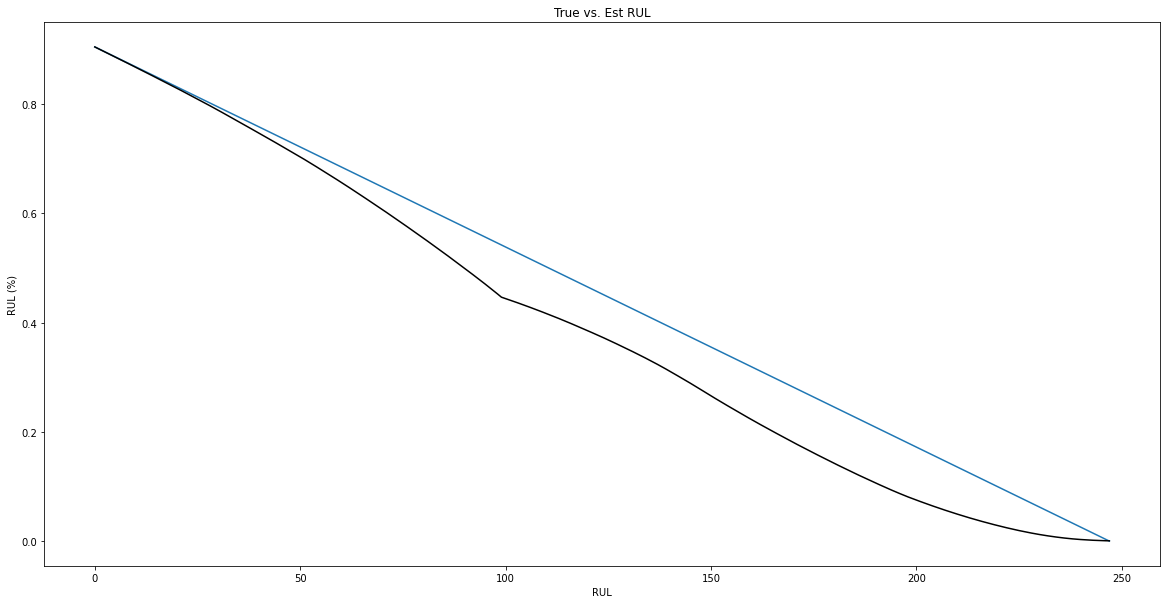

In [29]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(test_engine_df['NormTime'])
plt.plot(eval_df['NormTime'].iloc[:steps_to_go], color='black')
plt.title('True vs. Est RUL')
plt.xlabel('RUL')
plt.ylabel('RUL (%)')


(0.0, 1.0)

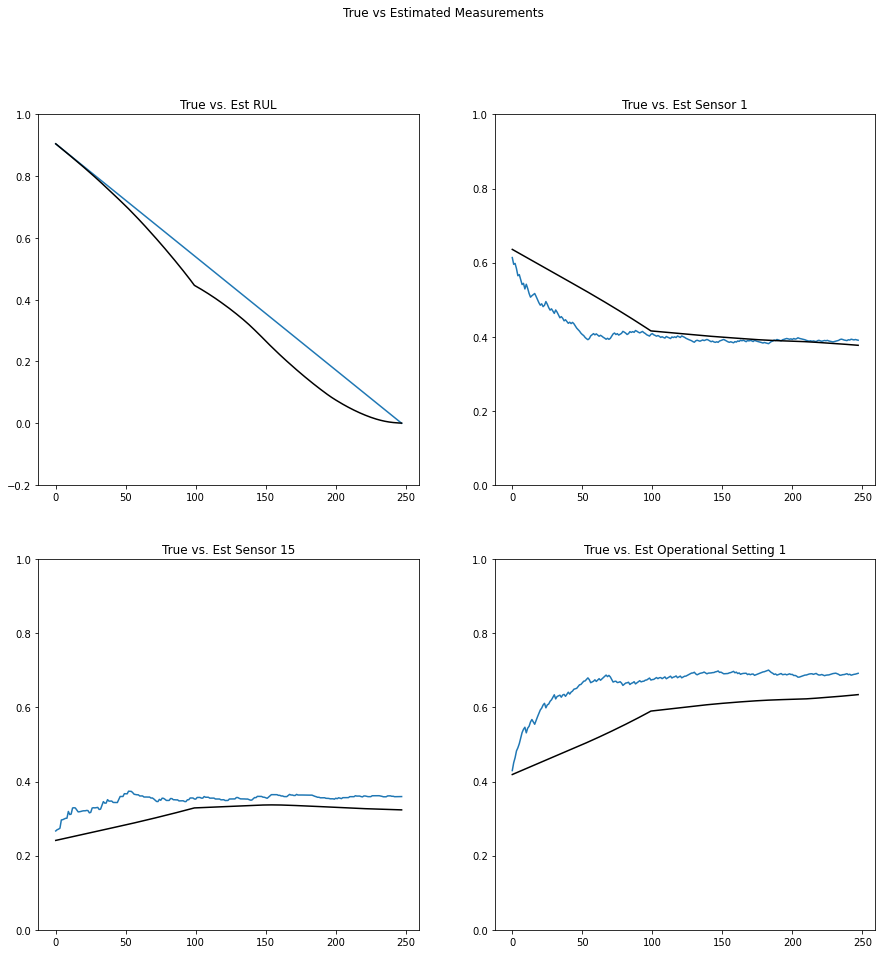

In [30]:
# '''
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('True vs Estimated Measurements')
plt.rcParams["figure.figsize"] = (10,10)

axs[0, 0].plot(test_engine_df['NormTime'])
axs[0, 0].plot(eval_df['NormTime'].iloc[:steps_to_go], color='black')
axs[0, 0].title.set_text('True vs. Est RUL')
axs[0, 0].set_ylim([-0.2,1])

axs[0, 1].plot(test_engine_df['Sensor2'])
axs[0, 1].plot(eval_df['Sensor2'].iloc[:steps_to_go], color='black')
axs[0, 1].title.set_text('True vs. Est Sensor 1')
axs[0, 1].set_ylim([0,1])

axs[1, 0].plot(test_engine_df['Sensor15'])
axs[1, 0].plot(eval_df['Sensor15'].iloc[:steps_to_go], color='black')
axs[1, 0].title.set_text('True vs. Est Sensor 15')
axs[1, 0].set_ylim([0,1])

axs[1, 1].plot(test_engine_df['OpSetting2'])
axs[1, 1].plot(eval_df['OpSetting2'].iloc[:steps_to_go], color='black')
axs[1, 1].title.set_text('True vs. Est Operational Setting 1')
axs[1, 1].set_ylim([0,1])


In [62]:
ray.shutdown()